<a href="https://colab.research.google.com/github/mlej8/ECSE552/blob/main/Tutorials/Tutorial5_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 5: Convolutional Networks

Goal: 
Learn how to implement a CNN and visualize its weights/activations

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Loading and Normalizing the CIFAR data

First we load the dataset and do the appropriate normalization. For this example we will use the CIFAR dataset

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
trainset[0][0].shape

torch.Size([3, 32, 32])

Let us try to visualize our data so that we have an idea fo what we are working on

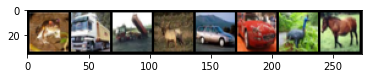

tensor([6, 9, 9, 4, 1, 1, 2, 7])
frog, truck, truck, deer, car, car, bird, horse


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

img = torchvision.utils.make_grid(images[:8]) # this just compiles our data in a single image
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0))) # channel dimension is last
plt.show()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(labels[:8])
print(', '.join('%s' % classes[labels[j]] for j in range(8)))

Now that we have the training data, we will calculate the mean and std of the training data for the normalization step. In this case we will use a channel-wise z-score normalization. Normalization is optional but is recommended.

In [5]:
chan_sum = torch.zeros(3)
chan_squared_sum = torch.zeros(3)

for img,_ in trainloader:
    # note that img is of size (batch, 3, 32, 32)
    chan_sum += torch.mean(img, dim=[0,2,3]) # channel mean across pixels and samples
    chan_squared_sum += torch.mean(img**2, dim=[0,2,3])

mean = chan_sum/len(trainloader)
std = torch.sqrt((chan_squared_sum/len(trainloader) - mean**2))  # var[X] = E[X**2] - E[X]**2

In [6]:
print("mean", mean)
print("std", std)

mean tensor([0.4915, 0.4822, 0.4466])
std tensor([0.2470, 0.2435, 0.2616])


We can then compose a series of transformation for our data when we are loading them.

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)])

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Now, let us visualize how the normalized data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


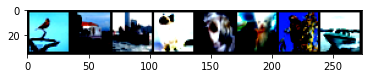

tensor([2, 9, 8, 3, 5, 3, 2, 8])
bird, truck, ship, cat, dog, cat, bird, ship


In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

img = torchvision.utils.make_grid(images[:8]) # this just compiles our data in a single image
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0))) # channel dimension is last
plt.show()

print(labels[:8])
print(', '.join('%s' % classes[labels[j]] for j in range(8)))

## Step 2: Setup the Network

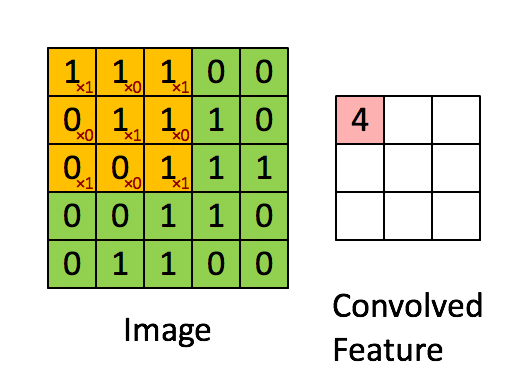

## Things you should know when setting up a CNN

### Input dimensions

* ``in_channels`` is the number of channels of your image if it is the first layer. Usually equivalent to the number of ``out_channels`` of your previous layer if it is not the first layer.

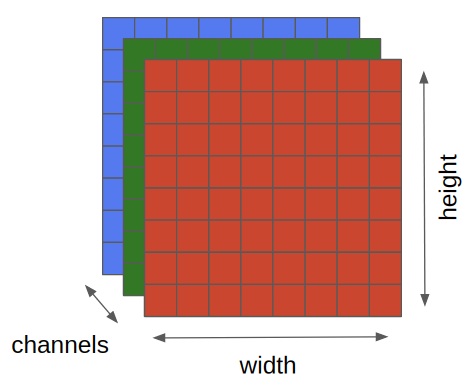

### Hyperparameters

* ``out_channels``: the number of channels you want to create for the convolution. This is the number of filters/kernels you are making

* ``kernel_size``: the size of your filter. Usually a square but you can opt to use a rectangular kernel by feeding this hyperparameter with a tuple 

* ``stride``: the number of cell units (pixels) when sliding the filters (2 means, skip 1 column/row when sliding)



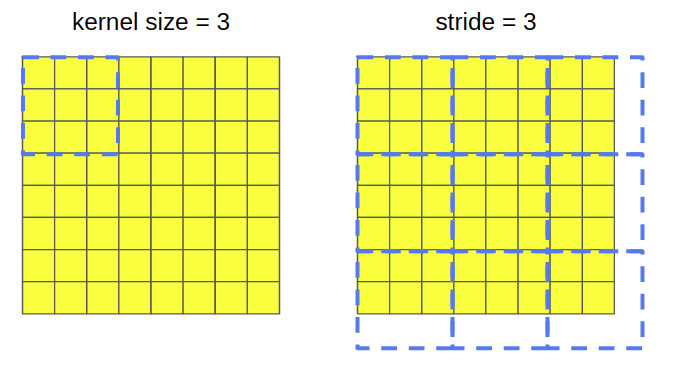

* ``padding``: amount of padding added to the input

* ``padding_mode``:


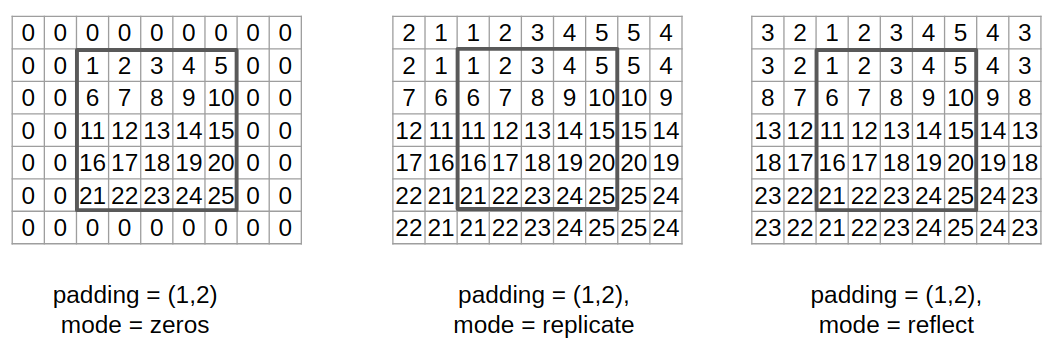


* ``dilation``:

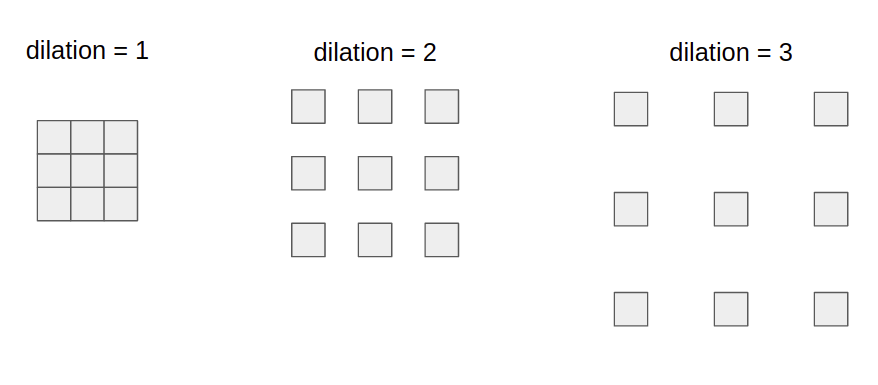

for more information about dilation, see the [original paper](https://arxiv.org/pdf/1511.07122.pdf).

### Output dimensions
The output size can be calculated using the following formula:

\begin{equation}
H_{out} = \lfloor \frac{H_{in} + 2 \times padding[0] - dilation[0] \times (kernel\_size[0] - 1) - 1}{stride[0]} \rfloor
\end{equation}

\begin{equation}
W_{out} = \lfloor \frac{W_{in} + 2 \times padding[1] - dilation[1] \times (kernel\_size[1] - 1) - 1}{stride[1]} \rfloor
\end{equation}

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        # 32 - 1*(5-1)-1 + 1 = 28 ~> (8, 28, 28)
        self.pool = nn.MaxPool2d(2, 2)
        # (28 - 1*(5-1)-1)/2 + 1 = 14
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        # 14 - 1*(5-1)-1 + 1 = 5 ~> (16, 5,5)
        self.fc1 = nn.Linear(16 * 5 * 5, 128) # since we have 16 output channels
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Step 3: Setup the optimizer and then train

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # combines nn.LogSoftmax() and nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [ ]:
num_epoch = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 4.369
[1,   400] loss: 3.864
[1,   600] loss: 3.716
[2,   200] loss: 3.497
[2,   400] loss: 3.384
[2,   600] loss: 3.328
[3,   200] loss: 3.201
[3,   400] loss: 3.175
[3,   600] loss: 3.109
[4,   200] loss: 3.033
[4,   400] loss: 3.018
[4,   600] loss: 2.972
[5,   200] loss: 2.933
[5,   400] loss: 2.902
[5,   600] loss: 2.885
[6,   200] loss: 2.838
[6,   400] loss: 2.831
[6,   600] loss: 2.806
[7,   200] loss: 2.762
[7,   400] loss: 2.784
[7,   600] loss: 2.718
[8,   200] loss: 2.721
[8,   400] loss: 2.691
[8,   600] loss: 2.701
[9,   200] loss: 2.654
[9,   400] loss: 2.633
[9,   600] loss: 2.620
[10,   200] loss: 2.580
[10,   400] loss: 2.591
[10,   600] loss: 2.578
[11,   200] loss: 2.564
[11,   400] loss: 2.547
[11,   600] loss: 2.534
[12,   200] loss: 2.476
[12,   400] loss: 2.501
[12,   600] loss: 2.500
[13,   200] loss: 2.474
[13,   400] loss: 2.437
[13,   600] loss: 2.433
[14,   200] loss: 2.419
[14,   400] loss: 2.387
[14,   600] loss: 2.418
[15,   200] loss: 2

# Step 4: Evaluate

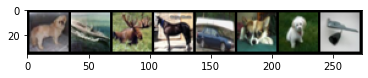

Predicted:  cat ship deer horse car horse dog plane
Label:  dog ship deer horse car dog dog plane


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = images[:8] * std.view(1,3,1,1) + mean.view(1,3,1,1) # unnormalize
img = torchvision.utils.make_grid(img) # this just compiles our data in a single image
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0))) # channel dimension is last
plt.show()

outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(8)))
print('Label: ', ' '.join('%s' % classes[labels[j]]
                              for j in range(8)))

In [ ]:
correct = 0
with torch.no_grad():
    for (images, labels) in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / len(testloader.dataset)))

Accuracy of the network on the 10000 test images: 58 %


In [ ]:
correct = 0
with torch.no_grad():
    for (images, labels) in trainloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 train images: %d %%' % (
    100 * correct / len(trainloader.dataset)))

# That's it! EZ Clap

Try changing some of the hyperparameters and adding some regularization techniques.|

## Visualizing filters and activations

(3, 9, 58)


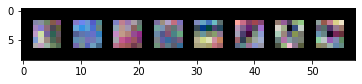

In [ ]:
filters = net.conv1.weight
filters = torchvision.utils.make_grid(filters, normalize=True)
npimg = filters.cpu().detach().numpy()
print(npimg.shape)
plt.imshow(np.transpose(npimg, (1, 2, 0))) # channel dimension is last
plt.show()


In [ ]:
class LowerNet(nn.Module):
    def __init__(self):
        super(LowerNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        # 32 - 1*(5-1)-1 + 1 = 28
        self.pool = nn.MaxPool2d(2, 2)
        # (28 - 1*(5-1)-1)/2 + 1 = 14

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        return x

lower_net = LowerNet()
lower_net.load_state_dict(net.state_dict(), strict=False)
lower_net = lower_net.to(device)

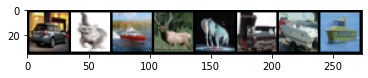

torch.Size([64, 8, 14, 14])


In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = images[:8] * std.view(1,3,1,1) + mean.view(1,3,1,1) # unnormalize
img = torchvision.utils.make_grid(img) # this just compiles our data in a single image
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0))) # channel dimension is last
plt.show()

with torch.no_grad():
  out = lower_net(images.to(device))

print(out.shape)

In [ ]:
npimg = torchvision.utils.make_grid(out[:8]).detach().cpu().numpy()
npimg.shape

(8, 18, 130)

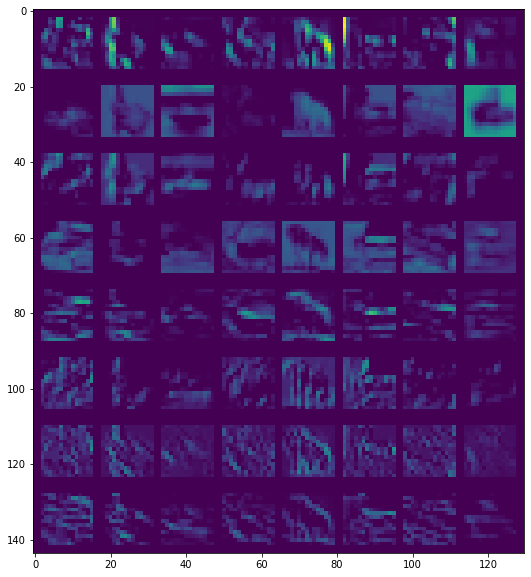

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(npimg.reshape(8*18,130))